# RCM city detection

Looking for urban effects in RCM simulations. Currently showing tasmin anomalies with respect to the city center on the day when tasmin in the city center was the largest on record for the ERA-Interim evaluation run.

## Load libraries

In [1]:
from pyesgf.logon import LogonManager
from pyesgf.search import SearchConnection
import cartopy.crs as ccrs
import dask
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import xarray as xr

## Functions and globals
The following commodity functions and globals could go to a separate script to be loaded.

In [2]:
os.environ["ESGF_PYCLIENT_NO_FACETS_STAR_WARNING"] = "1"
os.environ["MESA_LOADER_DRIVER_OVERRIDE"]="i965"
# Deal with non-standard names...
rlat_names = {'rlat', 'y'}
rlon_names = {'rlon', 'x'}
rotated_pole_names = {'rotated_pole', 'rotated_latitude_longitude', 'Lambert_Conformal'}

def search_dic(var, dom, rcm):
  return(dict(
    project='CORDEX',
    experiment=['evaluation',],
    rcm_name = rcm,
    domain = dom,
    variable=[var,],
    time_frequency = 'day',
    facets = 'dataset_id'
  ))

def select_name(names, avail_names):
  # Select variable/coordinate names among a list of potential names.
  # Potential names are matched against those available in the data set.
  return(list(names.intersection(list(avail_names)))[0])
    
def ESGF_login():
  lm = LogonManager()
  if not lm.is_logged_on():
    with open("openid.json") as fp:
      lm.logon_with_openid(**json.load(fp))
  if not lm.is_logged_on():
    print("/!\ There was some problem logging in")

def get_opendap_urls(vardic, ires=0):
  nodeURL = 'http://esgf-data.dkrz.de/esg-search'
  conn = SearchConnection(nodeURL, distrib=True)
  ctx = conn.new_context(**vardic)
  results = ctx.search(batch_size=200)
  dids = [result.dataset_id for result in results]
  files = results[ires].file_context().search()
  return([file.opendap_url for file in files])


def dump_netcdf(var, location, opendap_urls, nc):
  # Crop the area around the city and persist the data on a NetCDF file.
  # We need to log in to ESGF to actually retrieve data.
  ESGF_login()
  ds = xr.open_mfdataset(opendap_urls,
    parallel=True, chunks={'time':100},
    combine='nested', concat_dim='time',
    drop_variables = ['time_bnds']
  )
  #ds.isel(time=0).to_netcdf('test.nc')
  #
  #  Crop area around the city
  #
  dist = (ds['lon']-location[city]['lon'])**2 + (ds['lat']-location[city]['lat'])**2
  [ilat], [ilon] = np.where(dist == np.min(dist))
  ds_city = ds.isel(**{
    select_name(rlat_names, ds.coords): slice(ilat-dlat,ilat+dlat),
    select_name(rlon_names, ds.coords): slice(ilon-dlon,ilon+dlon)
  })
  ds_city.to_netcdf(nc, encoding = { var: {"zlib": True, "complevel": 9} })    

def plot_projected(index, dset):
  lonlat = ccrs.PlateCarree()
  projvar = select_name(rotated_pole_names, dset.data_vars)
  if projvar.startswith('rotated'):
    proj = ccrs.RotatedPole(
      pole_longitude=dset[projvar].grid_north_pole_longitude,
      pole_latitude=dset[projvar].grid_north_pole_latitude
    )
  else:
    proj = ccrs.LambertConformal(
      central_longitude=dset[projvar].longitude_of_central_meridian,
      central_latitude=dset[projvar].latitude_of_projection_origin,
      secant_latitudes=None,
      standard_parallels=[dset[projvar].standard_parallel]
    )
  f = plt.figure(figsize=(8,7))
  ax = plt.axes(projection=proj)
  index.plot.pcolormesh(
    #ax=ax, x='lon', y='lat', transform=lonlat, cmap=plt.cm.YlOrBr#, vmax=10
    ax=ax, x='lon', y='lat', transform=lonlat, cmap=plt.cm.RdBu_r, vmax=7
  )
  plt.title(dset.model_id)
  ax.coastlines(resolution='50m', linewidth=1, color='gray')
  ax.scatter(location[city]['lon'], location[city]['lat'], transform=lonlat, s=200, facecolor='none', edgecolor='grey')
  f.savefig(fname.replace('nc','png'), facecolor='white')
  plt.show()
  plt.close('all')
    
#
# Indices to identify urban areas
#
    
def index_argmax(ds):
  ''' Day with the maximum tasmin on the city
  
  Shows spatial anomalies with respect to this maximum tasmin
  '''
  rlon_name = select_name(rlon_names, ds.coords)
  rlat_name = select_name(rlat_names, ds.coords)
  rval = (
    ds[var]
      .isel(time = (
        ds[var]
           .isel(**{rlon_name: dlon, rlat_name: dlat})
           .argmax(dim='time')
           .values
        )
      )
  )
  rval = rval - rval.isel(**{rlon_name: dlon, rlat_name: dlat}).values
  return(rval)

def index_average_n_highest(ds, n = 10):
  ''' Average of n days with the largest tasmin on the city
  
  Averages spatial anomalies with respect to this maximum tasmin
  '''
  rlon_name = select_name(rlon_names, ds.coords)
  rlat_name = select_name(rlat_names, ds.coords)
  rval = (ds[var].isel(time = (ds[var]
    .isel(**{rlon_name: dlon, rlat_name: dlat})
    .argsort()[::-1][:n] # take the n highest
    .values
  )))
  rval = rval - rval.isel(**{rlon_name: dlon, rlat_name: dlat}).values[:,None,None]
  rval = rval.mean(dim='time')
  return(rval)

def index_quantile(ds):
  '''Quantile 0.95 of the anomalies w.r.t the spatial average
  '''
  return(
    (ds - ds.mean(dim=['rlon','rlat']))[var]
      .groupby('time.season')
      .quantile(0.95, 'time')
      .sel(season='JJA')
  )

compute_index = index_average_n_highest

## Main loop

In [3]:
var = 'tasmin'
rcms = {
  'EUR-11': [
    'REMO2015',
#    'RegCM4-6',  # ICTP server down
    'RACMO22E',
#    'HIRHAM5',
    'COSMO-crCLIM-v1-1',
#    'HadREM3-GA7-05',
    'CCLM4-8-17',
    'WRF381P'
  ],
  'EAS-22': [
#    'RegCM4-0', # No opendap access
    'REMO2015'
  ]
}
city = 'Paris'
location = dict(
     Beijing = dict(lon=116.41, lat=39.90, domain = 'EAS-22'),
      London = dict(lon= -0.13, lat=51.50, domain = 'EUR-11'),
      Madrid = dict(lon= -3.70, lat=40.42, domain = 'EUR-11'),
         NYC = dict(lon=-73.96, lat=40.73, domain = 'NAM-22'),
       Paris = dict(lon=  2.35, lat=48.85, domain = 'EUR-11'),
  Washington = dict(lon=-77.00, lat=38.90, domain = 'NAM-22')
)
dlon = dlat = int(20 / (int(location[city]['domain'].split('-')[1])/11))

Reading data for REMO2015 ...


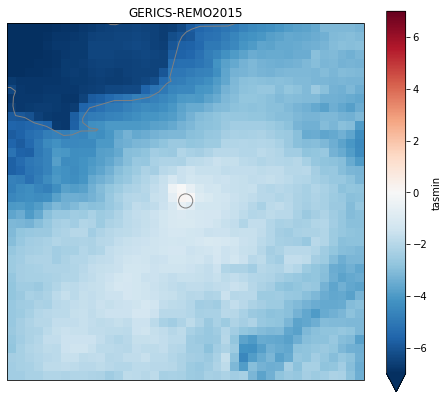

Reading data for RACMO22E ...


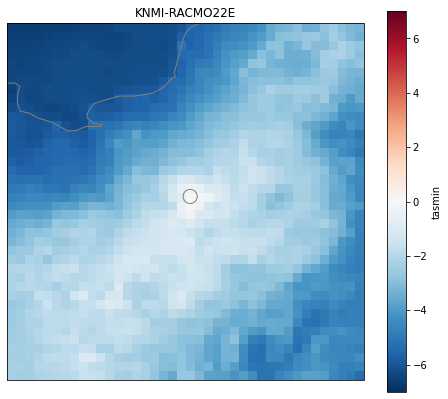

Reading data for COSMO-crCLIM-v1-1 ...


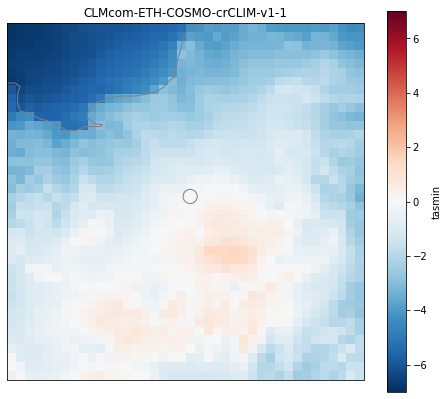

Reading data for CCLM4-8-17 ...


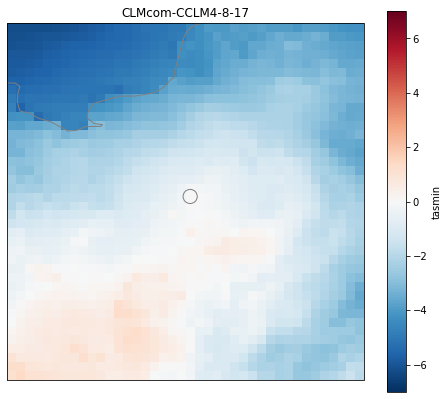

Reading data for WRF381P ...


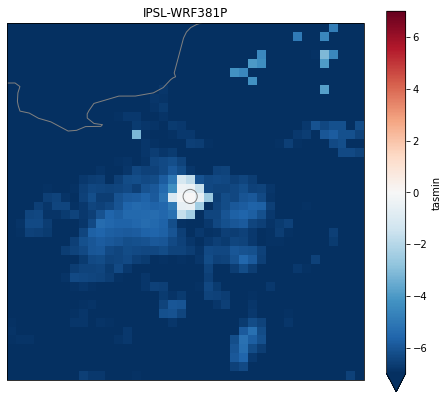

CPU times: user 6.18 s, sys: 983 ms, total: 7.16 s
Wall time: 42.8 s


In [4]:
%%time

for rcm in rcms[location[city]['domain']]:
  print(f'Reading data for {rcm} ...')
  opendap_urls = get_opendap_urls(search_dic(var, location[city]['domain'], rcm))
  fname = os.path.basename(opendap_urls[0])[:-21] + f'_{city}.nc'
  if not os.path.exists(fname):
    dump_netcdf(var, location, opendap_urls, fname)
  ds_city = xr.open_dataset(fname)
  index = compute_index(ds_city)
  plot_projected(index, ds_city)